In [1]:
import boto3
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, classification_report, precision_recall_curve

##defining the bucket
s3 = boto3.resource('s3')
bucket_name = 'rachaeld-data445'
bucket = s3.Bucket(bucket_name)

#defining the csv file
file_key = 'train.csv'
file_key2 = 'test.csv'

##train
bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

##test
bucket_object2 = bucket.Object(file_key2)
file_object2 = bucket_object2.get()
file_content_stream2 = file_object2.get('Body')

train = pd.read_csv(file_content_stream)
test = pd.read_csv(file_content_stream2)

In [2]:
train.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemsVoids,scansWithoutRegistration,quanitityModification,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,5,1054,54.70,7,0,3,0.027514,0.051898,0.241379,0
1,3,108,27.36,5,2,4,0.129630,0.253333,0.357143,0
2,3,1516,62.16,3,10,5,0.008575,0.041003,0.230769,0
3,6,1791,92.31,8,4,4,0.016192,0.051541,0.275862,0
4,5,430,81.53,3,7,2,0.062791,0.189605,0.111111,0


In [3]:
test.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition
0,4.0,467.0,88.48,4,8,4,0.014989,0.189465,0.571429
1,3.0,1004.0,58.99,7,6,1,0.026892,0.058755,0.259259
2,1.0,162.0,14.00,4,5,4,0.006173,0.086420,4.000000
3,5.0,532.0,84.79,9,3,4,0.026316,0.159380,0.642857
4,5.0,890.0,42.16,4,0,0,0.021348,0.047371,0.210526


In [36]:
print('train obs', train.shape[0])
print('test obs',test.shape[0])

##creating the frequency table of fraud (proportion)
print('fraud proportion below.')
train['fraud'].value_counts() / train.shape[0]

train obs 1879
test obs 498121
fraud proportion below.


0    0.944651
1    0.055349
Name: fraud, dtype: float64

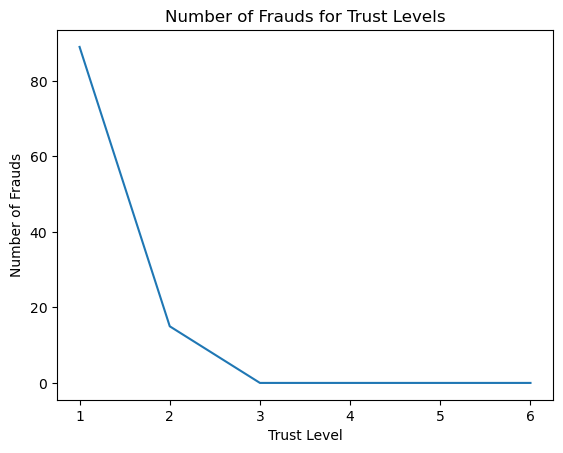

In [5]:
#fraud amount per trust level group 
trustlevel = train.groupby('trustLevel').sum()

plt.plot(trustlevel.index, trustlevel['fraud'])
plt.title('Number of Frauds for Trust Levels')
plt.xlabel('Trust Level')
plt.ylabel('Number of Frauds')
plt.show()

##from the plot we can see that the most fruad is seen in customers with a trust level of 1, and lessens as the trust level gets higher,
##ending at 3, where trust levels 3-5 all have no fraud accounted for. 

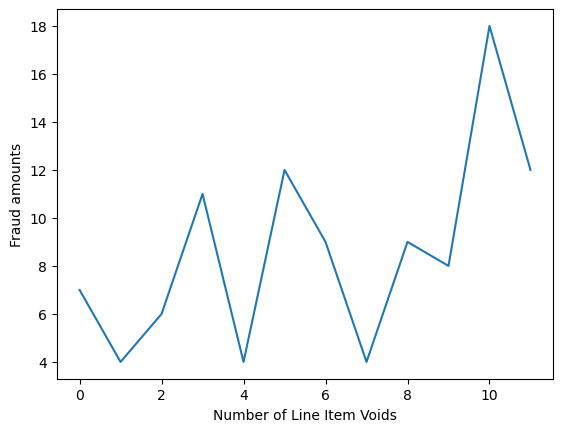

In [38]:
modif = train.groupby('lineItemsVoids').sum()

plt.plot(modif.index, modif['fraud'])
plt.xlabel('Number of Line Item Voids')
plt.ylabel('Fraud amounts')
plt.show()

##from the below plot we can see that the most amount of fraud is done when there is 10 item voids done in the group. There is not a true trend however of 'the more voids the more fraud'
## because we can see that there is low amounts of fraud even in higher amounts of voided items. So, there is not a huge correlation between number of voids and fraud. 

In [8]:
##picking most important variables. 
importance = pd.DataFrame(columns = train.columns).drop(columns = ['fraud'])

for i in range(0, 100):
    #defining the input and target variables
    X = train.drop(columns = ['fraud', ])
    Y = train['fraud']

    #splitting the data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = y)
    
    #building the model
    RF_md = RandomForestClassifier(n_estimators = 500, max_depth = 5).fit(X_train, Y_train)

    #extracting the feature importance
    importance.loc[i] = RF_md.feature_importances_.T

#average importance of each of the variables
pd.DataFrame({'Variable':importance.mean().index, 
              'Importance_Score':importance.mean().values}).sort_values(by = 'Importance_Score',
                                                                        ascending = False).reset_index(drop = True)

,Variable,Importance_Score
0,trustLevel,0.379647
1,scannedLineItemsPerSecond,0.153072
2,totalScanTimeInSeconds,0.135688
3,lineItemVoidsPerPosition,0.100973
4,valuePerSecond,0.079198
5,lineItemsVoids,0.055773
6,grandTotal,0.048999
7,scansWithoutRegistration,0.037305
8,quanitityModification,0.009345


In [27]:
## varaibles to pick: trustlevel, totalscantimeinseconds, lineitemviodsperposition, valuepersecond
##defining the input and target variables
X = train[['trustLevel', 'scannedLineItemsPerSecond', 'totalScanTimeInSeconds', 'lineItemVoidsPerPosition', 'valuePerSecond']]
Y = train['fraud']

##splitting the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .2, stratify = Y)

In [33]:
### RANDOM FOREST ###

##building the model
RF_md = RandomForestClassifier(n_estimators = 500, max_depth = 3).fit(X_train, Y_train)
##building the model

##predicting on the test dataset
RF_pred = RF_md.predict_proba(X_test)[:,1]

##precision recall curve
precision, recall, threshold = precision_recall_curve(Y_test, RF_pred)

##finding the optimal cutoff 
RF_cutoff = pd.DataFrame({'precision': precision[:-1], 'recall': recall[:-1], 'threshold': threshold})

##computing distance to perfect model
RF_cutoff['precision-1'] = RF_cutoff['precision']-1                                                                      
RF_cutoff['recall-1'] = RF_cutoff['recall']-1

##sorting based on distance
RF_cutoff['distance'] = np.sqrt(RF_cutoff['precision-1']**2 + RF_cutoff['recall-1']**2)
RF_cutoff= RF_cutoff.sort_values(by= 'distance', ascending= True).reset_index(drop = True)                       
                                                                                                           
##changing likelihoods to labels
RF_pred_label = np.where(RF_pred < RF_cutoff['threshold'][0], 0,1)

##classification report 
print('The cutoff used is', RF_cutoff['threshold'][0])
print(classification_report(Y_test, RF_pred_label))


The cutoff used is 0.2817290612345843
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       355
           1       0.65      0.81      0.72        21

    accuracy                           0.97       376
   macro avg       0.82      0.89      0.85       376
weighted avg       0.97      0.97      0.97       376



In [34]:
### ADABOOST ###

##building the model
ADA_md = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 5), n_estimators = 500, learning_rate =.01).fit(X_train, Y_train)

##predicting on the test dataset
ADA_pred = ADA_md.predict_proba(X_test)[:,1]

##precision recall curve
precision, recall, threshold = precision_recall_curve(Y_test, ADA_pred)

##finding the optimal cutoff 
ADA_cutoff = pd.DataFrame({'precision': precision[:-1], 'recall': recall[:-1], 'threshold': threshold})

##computing distance to perfect model
ADA_cutoff['precision-1'] = ADA_cutoff['precision']-1                                                                      
ADA_cutoff['recall-1'] = ADA_cutoff['recall']-1

##sorting based on distance
ADA_cutoff['distance'] = np.sqrt(ADA_cutoff['precision-1']**2 + ADA_cutoff['recall-1']**2)
ADA_cutoff= RF_cutoff.sort_values(by= 'distance', ascending= True).reset_index(drop = True)                       
                                                                                                           
##changing likelihoods to labels
ADA_pred_label = np.where(ADA_pred < ADA_cutoff['threshold'][0], 0,1)

##classification report 
print('The cutoff used is', ADA_cutoff['threshold'][0])
print(classification_report(Y_test, ADA_pred_label))


The cutoff used is 0.2817290612345843
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       355
           1       0.67      0.67      0.67        21

    accuracy                           0.96       376
   macro avg       0.82      0.82      0.82       376
weighted avg       0.96      0.96      0.96       376



In [ ]:
##based on the results above I would use the Radnom forest model to predict, this is because although it has 
##a lower precision score, it still has a higher recall and f-1 score compared to the adaboost model.